Crear una aplicación que detecte al menos 03 tipos de frutas (plátano, manzana, naranja). Luego, en una web utiliza este modelo y que al detectar una fruta indique un precio para cada fruta.
- plátano 1.50
- manzana 3.50
- naranja 4.30
 

In [4]:
# Importar librerias necesarias
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
# Importar las imagenes de (platano, manzana, naranja)
# Definir las rutas y las clases de frutas
IMG_SIZE = 128  # Tamaño al que redimensionaremos las imágenes
BATCH_SIZE = 32

# Mapeo de carpetas a etiquetas
fruit_folders = {
    'banana fruit': 'platano',
    'apple fruit': 'manzana', 
    'orange fruit': 'naranja'
}

# Función para cargar y preprocesar imágenes
def load_images(base_path, img_size=IMG_SIZE):
    images = []
    labels = []
    
    for folder, label in fruit_folders.items():
        folder_path = os.path.join(base_path, folder)
        print(f"Cargando imágenes de {folder}...")
        
        # Leer todas las imágenes de la carpeta
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            
            # Leer la imagen
            img = cv2.imread(img_path)
            if img is not None:
                # Convertir de BGR a RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Redimensionar la imagen
                img = cv2.resize(img, (img_size, img_size))
                # Normalizar los valores de píxeles a [0, 1]
                img = img / 255.0
                
                images.append(img)
                labels.append(label)
    
    return np.array(images), np.array(labels)

# Cargar todas las imágenes
X, y = load_images('./src/images')
print(f"\nTotal de imágenes cargadas: {len(X)}")
print(f"Forma de las imágenes: {X.shape}")
print(f"Clases: {np.unique(y)}")

Cargando imágenes de banana fruit...
Cargando imágenes de apple fruit...
Cargando imágenes de orange fruit...

Total de imágenes cargadas: 120
Forma de las imágenes: (120, 128, 128, 3)
Clases: ['manzana' 'naranja' 'platano']


In [6]:
# Convertir etiquetas a formato numérico


# Codificar las etiquetas de texto a números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convertir a formato categórico (one-hot encoding)
y_categorical = keras.utils.to_categorical(y_encoded, num_classes=3)

# Dividir los datos en entrenamiento y validación (80% entrenamiento, 20% validación)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Imágenes de entrenamiento: {len(X_train)}")
print(f"Imágenes de validación: {len(X_val)}")
print(f"\nMapeo de clases:")
for i, clase in enumerate(label_encoder.classes_):
    print(f"  {i}: {clase}")

Imágenes de entrenamiento: 96
Imágenes de validación: 24

Mapeo de clases:
  0: manzana
  1: naranja
  2: platano


In [7]:
model = keras.Sequential([
    # Extrae características básicas como bordes y colores
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),  # Reducir la dimensionalidad
    
    # Detecta patrones más complejos
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Captura características de alto nivel
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(), # Aplanar las características para las capas densas
    layers.Dropout(0.5), # Dropout para prevenir overfitting
    
    layers.Dense(128, activation='relu'),
    
    # Softmax convierte las salidas en probabilidades
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam', # Optimizador Adam
    loss='categorical_crossentropy', # Función de pérdida para clasificación multiclase
    metrics=['accuracy'] # Metrica para evaluar el rendimiento
)

C:\Users\Estudiante\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Entrenar el modelo
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=50,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.3646 - loss: 1.4457 - val_accuracy: 0.3333 - val_loss: 1.2164
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.3438 - loss: 1.1187 - val_accuracy: 0.5833 - val_loss: 1.0025
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6042 - loss: 0.9687 - val_accuracy: 0.5833 - val_loss: 0.7780
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7083 - loss: 0.7744 - val_accuracy: 0.7917 - val_loss: 0.6680
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7188 - loss: 0.6484 - val_accuracy: 0.7083 - val_loss: 0.7033
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7292 - loss: 0.5839 - val_accuracy: 0.7500 - val_loss: 0.6292
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8646 - loss: 0.4720 - val_accuracy: 0.8333 - val_loss: 0.7730
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8854 - loss: 0.3645 - val_accuracy: 0.7083 - val_loss:

In [9]:
# Evaluar el modelo con los datos de validación
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Precisión en validación: {val_accuracy*100:.2f}%")
print(f"Pérdida en validación: {val_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9167 - loss: 0.7898
Precisión en validación: 91.67%
Pérdida en validación: 0.7898


In [10]:
# Guardar el modelo entrenado
model.save('modelo_frutas.h5')
print("Modelo guardado como 'modelo_frutas.h5'")

# Guardar también el codificador de etiquetas
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Codificador de etiquetas guardado como 'label_encoder.pkl'")

Modelo guardado como 'modelo_frutas.h5'
Codificador de etiquetas guardado como 'label_encoder.pkl'


In [2]:
!tensorflowjs_converter --input_format=keras ./modelo_frutas.h5 ./tfjs_model

2025-12-12 17:43:44.635880: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-12 17:43:56.068745: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
C:\Users\Estudiante\AppData\Roaming\Python\Python313\site-packages\tensorflowjs\read_weights.py:28: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.uint8, np.uint16, np.object, np.bool]
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Estudiante\AppData\R

In [11]:
# Función para predecir una imagen y mostrar el precio
def predecir_fruta(imagen_path, mostrar=True):
    """
    Predice qué fruta es la imagen y muestra su precio
    
    Args:
        imagen_path: ruta de la imagen a predecir
        mostrar: si True, muestra la imagen con la predicción
    
    Returns:
        fruta predicha y precio
    """
    # Diccionario de precios
    precios = {
        'platano': 1.50,
        'manzana': 3.50,
        'naranja': 4.30
    }
    
    # Cargar y preprocesar la imagen
    img = cv2.imread(imagen_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    img_normalized = img_resized / 255.0
    
    # Añadir dimensión de batch (el modelo espera un lote de imágenes)
    img_batch = np.expand_dims(img_normalized, axis=0)
    
    # Realizar la predicción
    prediccion = model.predict(img_batch, verbose=0)
    clase_predicha = np.argmax(prediccion[0])
    confianza = prediccion[0][clase_predicha] * 100
    
    # Obtener el nombre de la fruta
    fruta = label_encoder.inverse_transform([clase_predicha])[0]
    precio = precios[fruta]
    
    if mostrar:
        plt.figure(figsize=(8, 6))
        plt.imshow(img_rgb)
        plt.title(f"Fruta: {fruta.upper()}\nPrecio: S/. {precio:.2f}\nConfianza: {confianza:.1f}%", 
                  fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.show()
    
    return fruta, precio, confianza

print("Función de predicción lista para usar")

Función de predicción lista para usar


Probando predicciones con imágenes de validación:



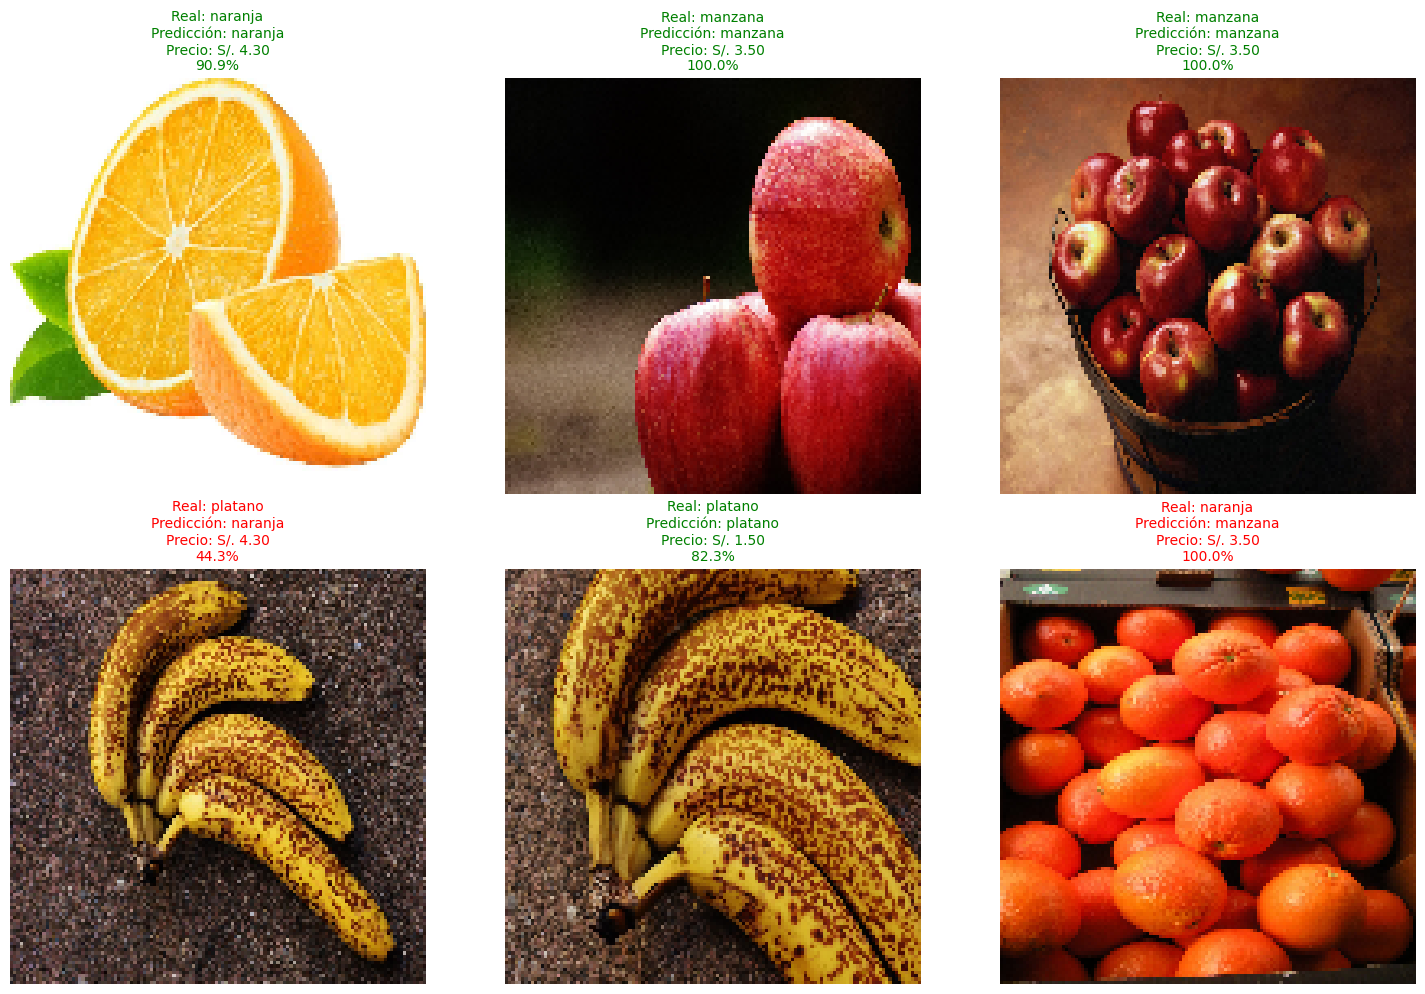

In [12]:
# Probar la predicción con algunas imágenes de validación
print("Probando predicciones con imágenes de validación:\n")

# Tomar 6 imágenes aleatorias del conjunto de validación
indices = np.random.choice(len(X_val), 6, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    # Obtener la imagen y su etiqueta real
    img = X_val[idx]
    etiqueta_real = label_encoder.inverse_transform([np.argmax(y_val[idx])])[0]
    
    # Predecir
    img_batch = np.expand_dims(img, axis=0)
    prediccion = model.predict(img_batch, verbose=0)
    clase_predicha = np.argmax(prediccion[0])
    confianza = prediccion[0][clase_predicha] * 100
    fruta_predicha = label_encoder.inverse_transform([clase_predicha])[0]
    
    # Obtener precio
    precios = {'platano': 1.50, 'manzana': 3.50, 'naranja': 4.30}
    precio = precios[fruta_predicha]
    
    # Mostrar
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    
    # Color verde si es correcto, rojo si es incorrecto
    color = 'green' if fruta_predicha == etiqueta_real else 'red'
    plt.title(f"Real: {etiqueta_real}\nPredicción: {fruta_predicha}\nPrecio: S/. {precio:.2f}\n{confianza:.1f}%",
              color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Aplicación Web para Detección de Frutas

A continuación se muestra cómo usar el modelo en una aplicación web Flask simple.

In [13]:
# Para ejecutar la aplicación web, ejecuta estos comandos en la terminal:
# 1. Asegúrate de tener Flask instalado: pip install flask
# 2. Ejecuta: python app_web.py
# 3. Abre tu navegador en: http://localhost:5000

print("""
╔══════════════════════════════════════════════════════════╗
║         APLICACIÓN WEB DE DETECCIÓN DE FRUTAS           ║
╚══════════════════════════════════════════════════════════╝

Para ejecutar la aplicación web:

1. Asegúrate de tener Flask instalado:
   pip install flask

2. Ejecuta la aplicación:
   python app_web.py

3. Abre tu navegador en:
   http://localhost:5000

4. Sube una imagen de una fruta (plátano, manzana o naranja)
   y la aplicación te dirá qué fruta es y su precio.

Precios configurados:
  🍌 Plátano: S/. 1.50
  🍎 Manzana: S/. 3.50
  🍊 Naranja: S/. 4.30
""")


╔══════════════════════════════════════════════════════════╗
║         APLICACIÓN WEB DE DETECCIÓN DE FRUTAS           ║
╚══════════════════════════════════════════════════════════╝

Para ejecutar la aplicación web:

1. Asegúrate de tener Flask instalado:
   pip install flask

2. Ejecuta la aplicación:
   python app_web.py

3. Abre tu navegador en:
   http://localhost:5000

4. Sube una imagen de una fruta (plátano, manzana o naranja)
   y la aplicación te dirá qué fruta es y su precio.

Precios configurados:
  🍌 Plátano: S/. 1.50
  🍎 Manzana: S/. 3.50
  🍊 Naranja: S/. 4.30

